In [2]:
library(WGCNA)
library(tidyverse)     # tidyverse will pull in ggplot2, readr, other useful libraries
library(magrittr)      # provides the %>% operator
library(DESeq2)
library(genefilter)

In [13]:
allowWGCNAThreads()          # allow multi-threading (optional)

Allowing multi-threading with up to 6 threads.


In [3]:
# The output of WGCNA is a list of clustered genes, and weighted gene correlation network files.

# ==== Load and clean data
data <- readr::read_delim("data/GSE61333_ligule_count.txt",     # <= path to the data file
                          delim = "\t")
data[1:5,1:10]        # Look at first 5 rows and 10 columns
names(data)[1] = "GeneId"
names(data)           # Look at the column names

Rows: 109715 Columns: 25
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: "\t"
chr  (1): Count
dbl (24): B-3, B-4, B-5, L-3, L-4, L-5, S-3, S-4, S-5, B_L1.1, B_L1.2, B_L1....

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Count,B-3,B-4,B-5,L-3,L-4,L-5,S-3,S-4,S-5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AC147602.5_FG004,0,0,0,0,0,0,0,0,0
AC148152.3_FG001,0,0,0,0,0,0,0,0,0
AC148152.3_FG002,0,0,0,0,0,0,0,0,0
AC148152.3_FG005,0,0,0,0,0,0,0,0,0
AC148152.3_FG006,0,0,0,0,0,0,0,0,0


[1] "GeneId" "B-3"    "B-4"    "B-5"    "L-3"    "L-4"    "L-5"    "S-3"   
 [9] "S-4"    "S-5"    "B_L1.1" "B_L1.2" "B_L1.3" "L_L1.1" "L_L1.2" "L_L1.3"
[17] "S_L1.1" "S_L1.2" "S_L1.3" "wtL-1"  "wtL-2"  "wtL-3"  "lg1-1"  "lg1-2" 
[25] "lg1-3"

In [4]:
col_sel = names(data)[-1]     # Get all but first column name
mdata <- data %>%
  tidyr::pivot_longer(
    .,                        # The dot is the the input data, magrittr tutorial
    col = all_of(col_sel)
  ) %>%  
  mutate(
    group = gsub("-.*","", name) %>% gsub("[.].*","", .)   # Get the shorter treatment names
  )

### Блок ниже самый продолжительный по времени

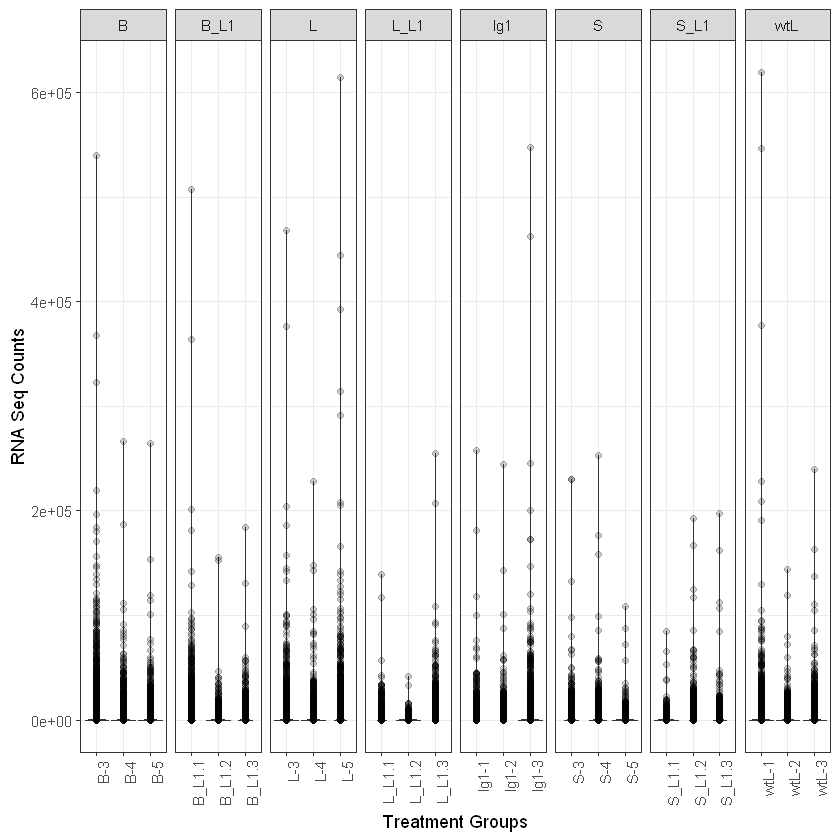

In [5]:
# ==== Plot groups (Sample Groups vs RNA Seq Counts) to identify outliers
(
  p <- mdata %>%
    ggplot(., aes(x = name, y = value)) +             # x = treatment, y = RNA Seq count
    geom_violin() +                                   # violin plot, show distribution
    geom_point(alpha = 0.2) +                         # scatter plot
    theme_bw() +
    theme(
      axis.text.x = element_text(angle = 90)          # Rotate treatment text
    ) +
    labs(x = "Treatment Groups", y = "RNA Seq Counts") +
    facet_grid(cols = vars(group), drop = TRUE, scales = "free_x")      # Facet by hour
)

In [6]:
# Normalize Counts with DESeq
# Prepare DESeq input, which is expecting a matrix of integers.
de_input = as.matrix(data[,-1])
row.names(de_input) = data$GeneId
de_input[1:5,1:10]

meta_df <- data.frame( Sample = names(data[-1])) %>%
  mutate(
    Type = gsub("-.*","", Sample) %>% gsub("[.].*","", .)
  )

dds <- DESeqDataSetFromMatrix(round(de_input),
                              meta_df,
                              design = ~Type)
dds <- DESeq(dds)

,B-3,B-4,B-5,L-3,L-4,L-5,S-3,S-4,S-5,B_L1.1
AC147602.5_FG004,0,0,0,0,0,0,0,0,0,0
AC148152.3_FG001,0,0,0,0,0,0,0,0,0,0
AC148152.3_FG002,0,0,0,0,0,0,0,0,0,0
AC148152.3_FG005,0,0,0,0,0,0,0,0,0,0
AC148152.3_FG006,0,0,0,0,0,0,0,0,0,0


converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [7]:
wpn_vsd <- getVarianceStabilizedData(dds)
rv_wpn <- rowVars(wpn_vsd)
summary(rv_wpn)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.00000  0.00000  0.00000  0.08044  0.03322 11.14529 

In [8]:
q75_wpn <- quantile( rowVars(wpn_vsd), .75)  # <= original
q95_wpn <- quantile( rowVars(wpn_vsd), .95)  # <= changed to 95 quantile to reduce dataset
expr_normalized <- wpn_vsd[ rv_wpn > q95_wpn, ]
expr_normalized[1:5,1:10]
dim(expr_normalized)

,B-3,B-4,B-5,L-3,L-4,L-5,S-3,S-4,S-5,B_L1.1
AC149818.2_FG001,7.600901,7.077399,7.803434,7.220840,7.410408,8.028223,7.160846,7.401382,7.345322,6.524435
AC149829.2_FG003,8.782014,8.179876,7.900062,8.299778,7.529891,8.631731,8.055118,8.744502,8.142909,8.240407
AC182617.3_FG001,8.047244,7.120668,6.885533,7.501391,7.279413,7.809565,7.184253,8.140134,6.972400,7.777347
AC186512.3_FG001,6.901539,7.389644,6.975945,6.859593,7.370816,6.633722,7.798843,6.949501,6.952659,6.059033
AC186512.3_FG007,7.919688,7.754506,7.670946,7.417760,7.988427,7.904850,7.484542,8.375664,7.762799,6.335663


[1] 5486   24

In [9]:
expr_normalized_df <- data.frame(expr_normalized) %>%
  mutate(
    Gene_id = row.names(expr_normalized)
  ) %>%
  pivot_longer(-Gene_id)

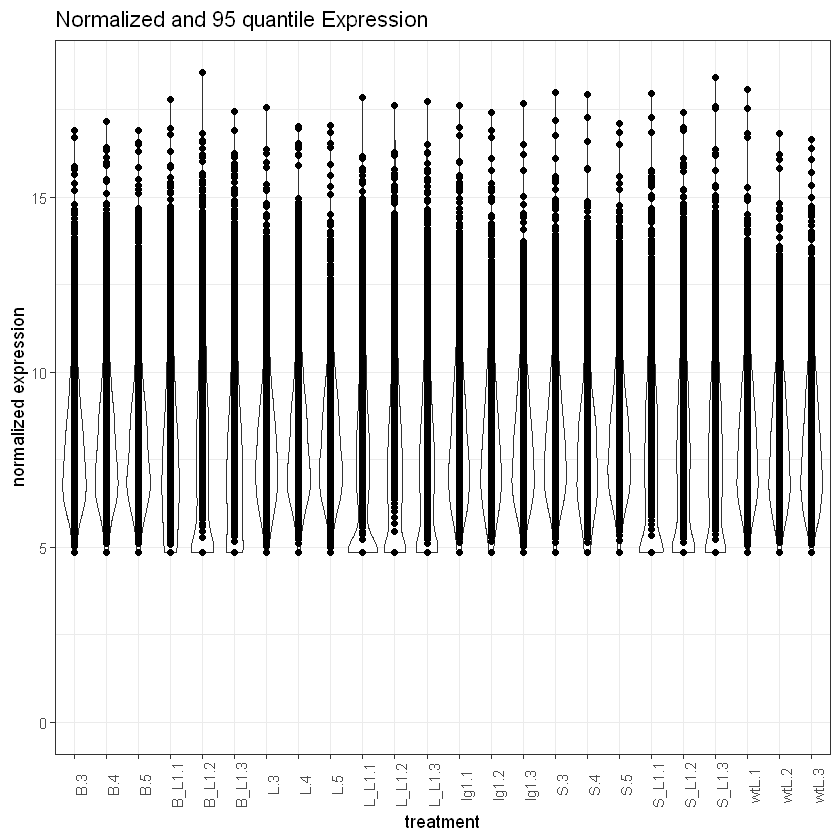

In [10]:
expr_normalized_df %>% ggplot(., aes(x = name, y = value)) +
  geom_violin() +
  geom_point() +
  theme_bw() +
  theme(
    axis.text.x = element_text( angle = 90)
  ) +
  ylim(0, NA) +
  labs(
    title = "Normalized and 95 quantile Expression",
    x = "treatment",
    y = "normalized expression"
  )

In [11]:
# WGCNA
# Rows = treatments and columns = gene probes
input_mat = t(expr_normalized)
input_mat[1:5,1:10]           # Look at first 5 rows and 10 columns

,AC149818.2_FG001,AC149829.2_FG003,AC182617.3_FG001,AC186512.3_FG001,AC186512.3_FG007,AC189795.3_FG001,AC190609.3_FG002,AC190623.3_FG001,AC192451.3_FG001,AC195340.3_FG001
B-3,7.600901,8.782014,8.047244,6.901539,7.919688,8.149041,12.64301,6.575155,6.700385,9.104258
B-4,7.077399,8.179876,7.120668,7.389644,7.754506,8.077571,11.99816,7.170788,7.325447,9.135480
B-5,7.803434,7.900062,6.885533,6.975945,7.670946,7.524430,12.12500,7.438024,7.819142,9.023856
L-3,7.220840,8.299778,7.501391,6.859593,7.417760,8.420552,12.36979,8.223261,8.052019,8.908933
L-4,7.410408,7.529891,7.279413,7.370816,7.988427,7.105196,11.64515,8.008850,8.528875,8.583982


Allowing multi-threading with up to 6 threads.


In [12]:
# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to = 20, by = 2))
# Call the network topology analysis function
sft = pickSoftThreshold(
  input_mat,             # <= Input data
  #blockSize = 30,
  powerVector = powers,
  verbose = 5
)

pickSoftThreshold: will use block size 5486.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 5486 of 5486
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.5350  2.500          0.960  1940.0    1950.0   2840
2      2   0.0642  0.331          0.897   964.0     927.0   1860
3      3   0.1680 -0.444          0.859   560.0     505.0   1340
4      4   0.5050 -0.822          0.906   358.0     300.0   1030
5      5   0.6800 -1.070          0.935   243.0     189.0    819
6      6   0.7770 -1.230          0.954   173.0     125.0    673
7      7   0.8330 -1.310          0.972   127.0      85.3    564
8      8   0.8660 -1.390          0.980    96.4      60.2    484
9      9   0.8810 -1.450          0.981    74.8      43.2    422
10    10   0.8940 -1.490          0.984    59.1      31.7    371
11    12   0.9070 -1.540          0.988    38.7      17.6    295
12    14   0.9150 -1.580          0.988    26.7      10.3    240


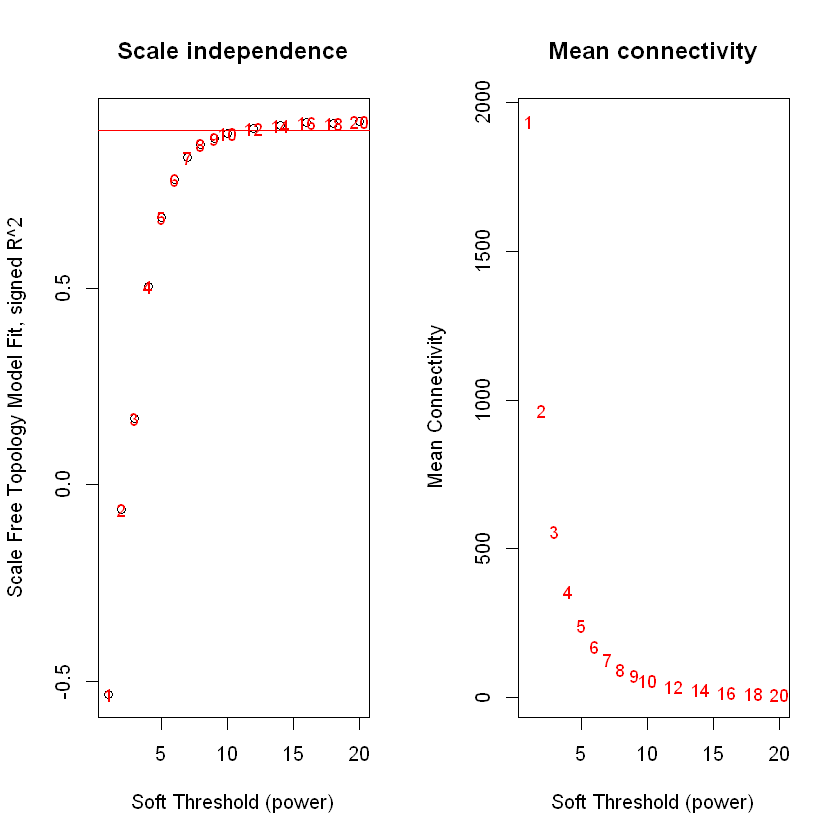

In [16]:
par(mfrow = c(1,2));
cex1 = 0.9;
plot(sft$fitIndices[, 1],
     -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     xlab = "Soft Threshold (power)",
     ylab = "Scale Free Topology Model Fit, signed R^2",
     main = paste("Scale independence")
)

text(sft$fitIndices[, 1],
     -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     labels = powers, cex = cex1, col = "red"
)
abline(h = 0.90, col = "red")
plot(sft$fitIndices[, 1],
     sft$fitIndices[, 5],
     xlab = "Soft Threshold (power)",
     ylab = "Mean Connectivity",
     type = "n",
     main = paste("Mean connectivity")
)
text(sft$fitIndices[, 1],
     sft$fitIndices[, 5],
     labels = powers,
     cex = cex1, col = "red")

In [17]:
picked_power = 9
temp_cor <- cor       
cor <- WGCNA::cor         # Force it to use WGCNA cor function (fix a namespace conflict issue)
netwk <- blockwiseModules(input_mat,                # <= input here
                          
                          # == Adjacency Function ==
                          power = picked_power,                # <= power here
                          networkType = "signed",
                          
                          # == Tree and Block Options ==
                          deepSplit = 2,
                          pamRespectsDendro = F,
                          # detectCutHeight = 0.75,
                          minModuleSize = 30,
                          maxBlockSize = 4000,
                          
                          # == Module Adjustments ==
                          reassignThreshold = 0,
                          mergeCutHeight = 0.25,
                          
                          # == TOM == Archive the run results in TOM file (saves time)
                          saveTOMs = T,
                          saveTOMFileBase = "ER",
                          
                          # == Output Options
                          numericLabels = T,
                          verbose = 3)

cor <- temp_cor     # Return cor function to original namespace

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ....pre-clustering genes to determine blocks..
   Projective K-means:
   ..k-means clustering..
   ..merging smaller clusters...
Block sizes:
gBlocks
   1    2 
3489 1997 
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file ER-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 31 genes from module 1 because their KME is too low.
     ..removing 27 genes from module 2 because their KME is too low.
     ..removing 1 genes from module 3 because their KME is too low.
     ..removing 1 genes from module 5 because their KME is too low.
     ..removing 1 g

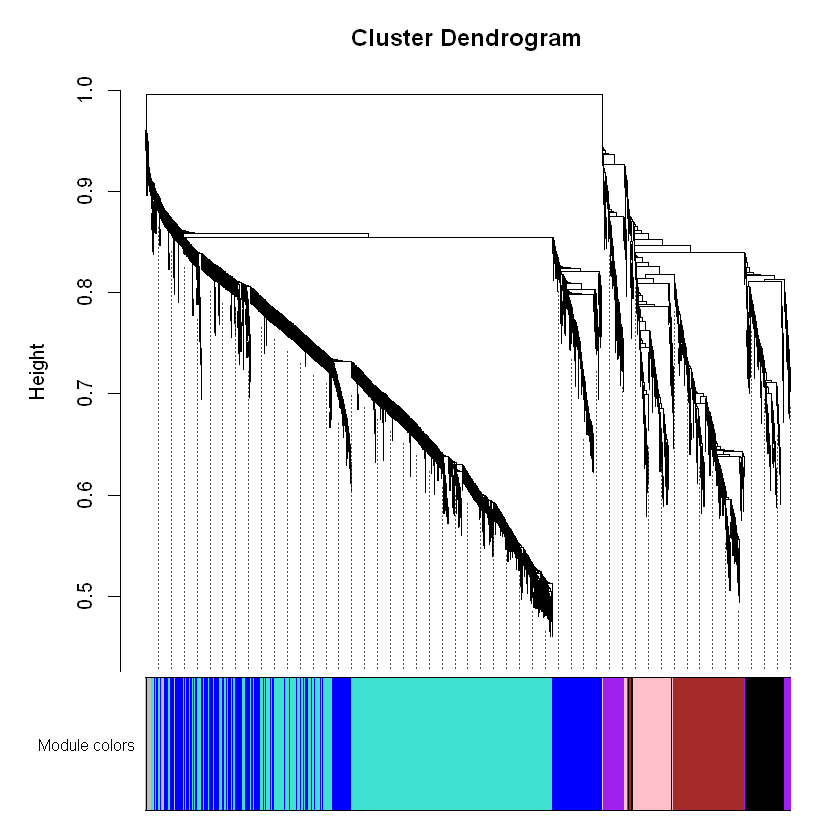

In [18]:
# Convert labels to colors for plotting
mergedColors = labels2colors(netwk$colors)
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(
  netwk$dendrograms[[1]],
  mergedColors[netwk$blockGenes[[1]]],
  "Module colors",
  dendroLabels = FALSE,
  hang = 0.03,
  addGuide = TRUE,
  guideHang = 0.05 )

In [19]:
module_df <- data.frame(
  gene_id = names(netwk$colors),
  colors = labels2colors(netwk$colors)
)

In [20]:
# Relate Module (cluster) Assignments to Treatment Groups
# Pull out the list of modules

module_df[1:5,]
write_delim(module_df,
            file = "gene_modules.txt",
            delim = "\t")

# Get Module Eigengenes per cluster
MEs0 <- moduleEigengenes(input_mat, mergedColors)$eigengenes

# Reorder modules so similar modules are next to each other
MEs0 <- orderMEs(MEs0)
module_order = names(MEs0) %>% gsub("ME","", .)
# Add treatment names
MEs0$treatment = row.names(MEs0)

,gene_id,colors
,<chr>,<chr>
1,AC149818.2_FG001,blue
2,AC149829.2_FG003,blue
3,AC182617.3_FG001,blue
4,AC186512.3_FG001,turquoise
5,AC186512.3_FG007,turquoise


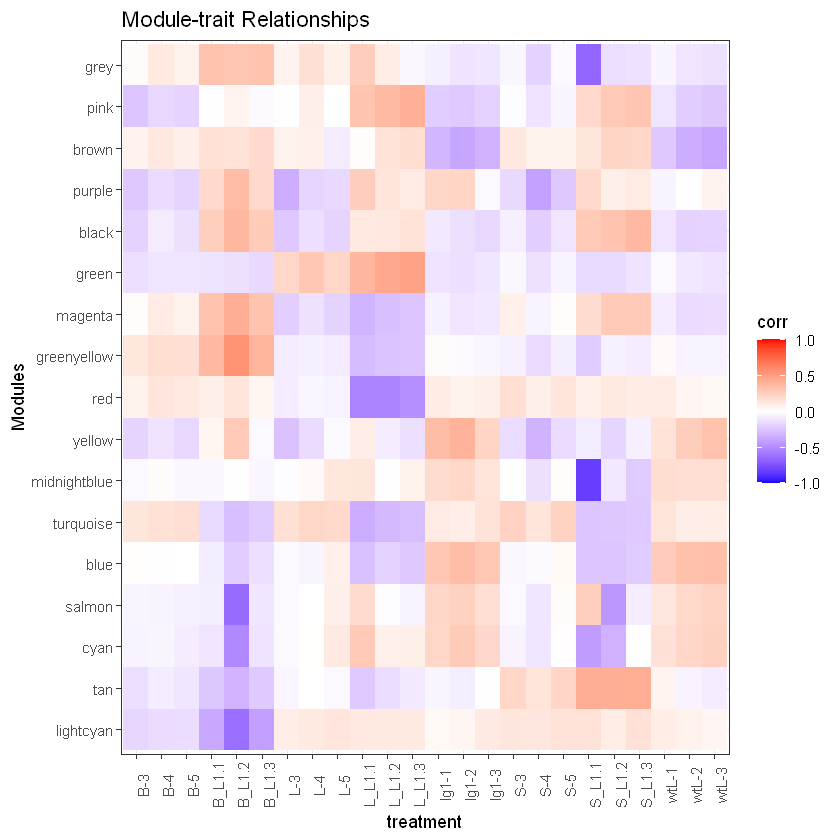

In [21]:
# tidy & plot data
mME = MEs0 %>%
  pivot_longer(-treatment) %>%
  mutate(
    name = gsub("ME", "", name),
    name = factor(name, levels = module_order)
  )

mME %>% ggplot(., aes(x=treatment, y=name, fill=value)) +
  geom_tile() +
  theme_bw() +
  scale_fill_gradient2(
    low = "blue",
    high = "red",
    mid = "white",
    midpoint = 0,
    limit = c(-1,1)) +
  theme(axis.text.x = element_text(angle=90)) +
  labs(title = "Module-trait Relationships", y = "Modules", fill="corr")

In [22]:
# Examine Expression Profiles

# pick out a few modules of interest here
modules_of_interest = c("green", "turquoise", "tan")

# Pull out list of genes in that module
submod = module_df %>%
  subset(colors %in% modules_of_interest)

row.names(module_df) = module_df$gene_id

# Get normalized expression for those genes
expr_normalized[1:5,1:10]

subexpr = expr_normalized[submod$gene_id,]

,B-3,B-4,B-5,L-3,L-4,L-5,S-3,S-4,S-5,B_L1.1
AC149818.2_FG001,7.600901,7.077399,7.803434,7.220840,7.410408,8.028223,7.160846,7.401382,7.345322,6.524435
AC149829.2_FG003,8.782014,8.179876,7.900062,8.299778,7.529891,8.631731,8.055118,8.744502,8.142909,8.240407
AC182617.3_FG001,8.047244,7.120668,6.885533,7.501391,7.279413,7.809565,7.184253,8.140134,6.972400,7.777347
AC186512.3_FG001,6.901539,7.389644,6.975945,6.859593,7.370816,6.633722,7.798843,6.949501,6.952659,6.059033
AC186512.3_FG007,7.919688,7.754506,7.670946,7.417760,7.988427,7.904850,7.484542,8.375664,7.762799,6.335663


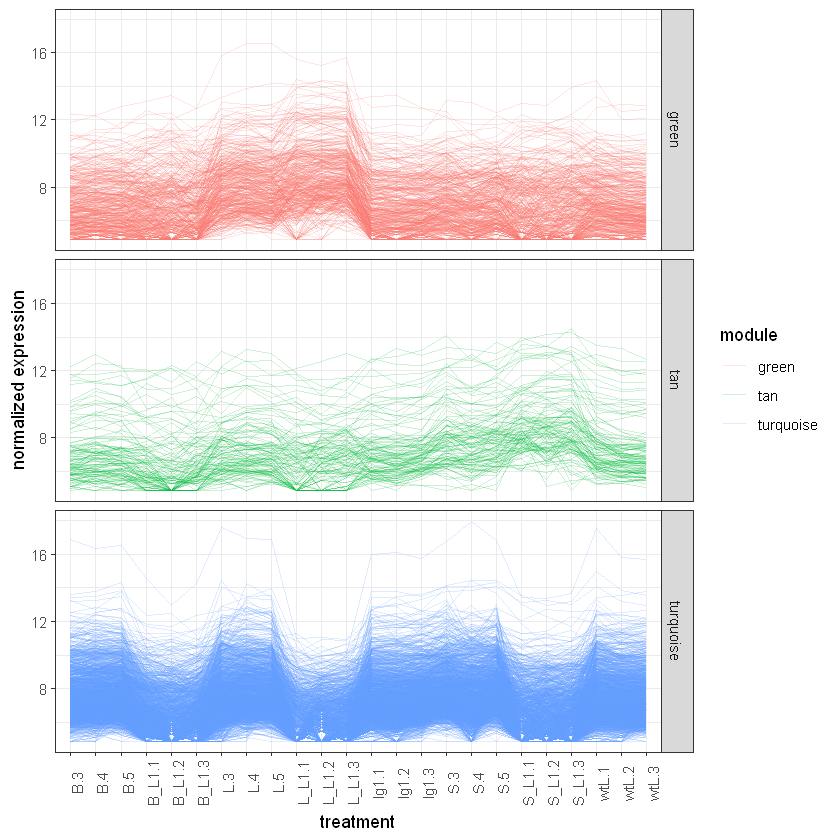

In [23]:
submod_df = data.frame(subexpr) %>%
  mutate(
    gene_id = row.names(.)
  ) %>%
  pivot_longer(-gene_id) %>%
  mutate(
    module = module_df[gene_id,]$colors
  )

submod_df %>% ggplot(., aes(x=name, y=value, group=gene_id)) +
  geom_line(aes(color = module),
            alpha = 0.2) +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90)
  ) +
  facet_grid(rows = vars(module)) +
  labs(x = "treatment",
       y = "normalized expression")

In [24]:
# Generate and Export Networks
# The network file can be generated for Cytoscape or as an edge/vertices file.

genes_of_interest = module_df %>%
  subset(colors %in% modules_of_interest)

expr_of_interest = expr_normalized[genes_of_interest$gene_id,]
expr_of_interest[1:5,1:5]

,B-3,B-4,B-5,L-3,L-4
AC186512.3_FG001,6.901539,7.389644,6.975945,6.859593,7.370816
AC186512.3_FG007,7.919688,7.754506,7.670946,7.417760,7.988427
AC190623.3_FG001,6.575155,7.170788,7.438024,8.223261,8.008850
AC196475.3_FG004,6.054319,6.439899,6.424540,5.815344,6.565299
AC196475.3_FG005,6.194406,5.872273,6.207174,6.499828,6.314952


In [25]:
# Only recalculate TOM for modules of interest (faster, altho there's 
# some online discussion if this will be slightly off)
TOM = TOMsimilarityFromExpr(t(expr_of_interest),
                            power = picked_power)
# Add gene names to row and columns
row.names(TOM) = row.names(expr_of_interest)
colnames(TOM) = row.names(expr_of_interest)

TOM calculation: adjacency..
..will not use multithreading.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [26]:
edge_list = data.frame(TOM) %>%
  mutate(
    gene1 = row.names(.)
  ) %>%
  pivot_longer(-gene1) %>%
  dplyr::rename(gene2 = name, correlation = value) %>%
  unique() %>%
  subset(!(gene1==gene2)) %>%
  mutate(
    module1 = module_df[gene1,]$colors,
    module2 = module_df[gene2,]$colors
  )

head(edge_list)

gene1,gene2,correlation,module1,module2
<chr>,<chr>,<dbl>,<chr>,<chr>
AC186512.3_FG001,AC186512.3_FG007,0.02379539,turquoise,turquoise
AC186512.3_FG001,AC190623.3_FG001,0.07191482,turquoise,turquoise
AC186512.3_FG001,AC196475.3_FG004,0.14308298,turquoise,turquoise
AC186512.3_FG001,AC196475.3_FG005,0.01174263,turquoise,turquoise
AC186512.3_FG001,AC196489.3_FG002,0.01813684,turquoise,turquoise
AC186512.3_FG001,AC198481.3_FG004,0.02404695,turquoise,turquoise


In [27]:
write_delim(edge_list,
            file = "edgelist.tsv",
            delim = "\t")

In [28]:
# We have taken in RNASeq count information, identified the 
# top (95% quantile) differentially expressed genes, sent it to WGCNA 
# to identify modules and create the gene correlation network for those modules.